# Phân tích đoạn văn bản, dùng double merge để vẽ context rộng hơn cho việc trả lời câu hỏi.

- Cần check xem có hiệu quả không, vì dùng spacy tính similarity giữa câu hỏi và đoạn văn bản có vẻ tương đồng, dù là đoạn text khá xa.

In [1]:
!pip install llama-index-core
!pip install llama_index
!pip install llama-index-llms-openai
!pip install matplotlib
!pip install spacy
!pip install pyvi

In [2]:
!pip install python-dotenv

In [3]:
from llama_index.core import VectorStoreIndex
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
    SemanticDoubleMergingSplitterNodeParser,
    LanguageConfig,
)
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import SimpleDirectoryReader
import os
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env.
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

In [ ]:
# Install the Vietnamese spaCy model
# !pip install https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz

In [5]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords corpus
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /Users/ngocp/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /Users/ngocp/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
import spacy

# Load the Vietnamese spaCy model
nlp = spacy.load('vi_core_news_lg')

# Example text
doc = nlp('Cộng đồng xử lý ngôn ngữ tự nhiên')

# Print token information
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
          token.shape_, token.is_alpha, token.is_stop)

Cộng đồng   V ROOT Xxxx xxxx False False
xử lý   N obj xx xx False False
ngôn ngữ   V xcomp xxxx xxx False False
tự nhiên   N compound xx xxxx False False


In [7]:
from typing import Dict, List

documents = SimpleDirectoryReader(input_dir="../data").load_data()

LANGUAGE_MODELS: Dict[str, List[str]] = {
    "english": ["en_core_web_md", "en_core_web_lg"],
    "german": ["de_core_news_md", "de_core_news_lg"],
    "spanish": ["es_core_news_md", "es_core_news_lg"],
    "vietnamese": ["vi_core_news_lg"],  # Add Vietnamese language models
}

class VietnameseLanguageConfig(LanguageConfig):
    def __init__(
        self,
        language: str = "english",
        spacy_model: str = "en_core_web_md",
        model_validation: bool = True,
    ):
        if language not in LANGUAGE_MODELS:
            raise ValueError(
                f"{language} language is not supported yet! Available languages: {list(LANGUAGE_MODELS.keys())}"
            )
        self.language = language
        self.spacy_model = spacy_model
        self.model_validation = model_validation
        if self.model_validation:
            self.validate_model()

    def validate_model(self):
        if self.spacy_model not in LANGUAGE_MODELS[self.language]:
            raise ValueError(
                f"{self.spacy_model} is not a valid model for {self.language}. Available models: {LANGUAGE_MODELS[self.language]}"
            )

config = VietnameseLanguageConfig(language="vietnamese", spacy_model="vi_core_news_lg")

splitter = SemanticDoubleMergingSplitterNodeParser(
    language_config=config,
    initial_threshold=0.4,
    appending_threshold=0.5,
    merging_threshold=0.5,
    max_chunk_size=5000,
)

In [8]:
print(len(documents))

3


In [9]:
nodes = splitter.get_nodes_from_documents(documents)
print(len(nodes))

/Users/ngocp/Documents/projects/tu-vi-bot/.venv/lib/python3.10/site-packages/llama_index/core/node_parser/text/semantic_double_merging_splitter.py:228: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  ).similarity(
/Users/ngocp/Documents/projects/tu-vi-bot/.venv/lib/python3.10/site-packages/llama_index/core/node_parser/text/semantic_double_merging_splitter.py:255: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  ).similarity(
/Users/ngocp/Documents/projects/tu-vi-bot/.venv/lib/python3.10/site-packages/llama_index/core/node_parser/text/semantic_double_merging_splitter.py:328: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  and current_nlp.similarity(
/Users/ngocp/Documents/projects/tu-vi-bot/.venv/lib/python3.10/site-packages/llama_index/core/node_parser/text/semantic_double_merging_splitter.py:310: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  and current_nlp.similarity(
/Users/ngocp/Documen

122


In [18]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


## Vẽ biểu đồ và tính độ tương quang giữa câu hỏi và đoạn văn bản

node Node ID: bfe102a1-2719-457b-9704-cef0d4119990
Text: Trực giác - Cần phải có trực giác bén nhạy để giúp ích cho những
sự suy luận.
Similarity between node 40 and node 1: 0.8374055956950703
Similarity between node 41 and node 1: 0.8499876741695488
Similarity between node 42 and node 1: 0.8415213123667166
Similarity between node 43 and node 1: 0.8431831051477956
Similarity between node 44 and node 1: 0.8477029860926423
Similarity between node 45 and node 1: 0.8457184951358954
Similarity between node 46 and node 1: 0.7039391379099728
Similarity between node 47 and node 1: 0.8328001856582115
Similarity between node 48 and node 1: 0.830544874761436
Similarity between node 49 and node 1: 0.832585287780577


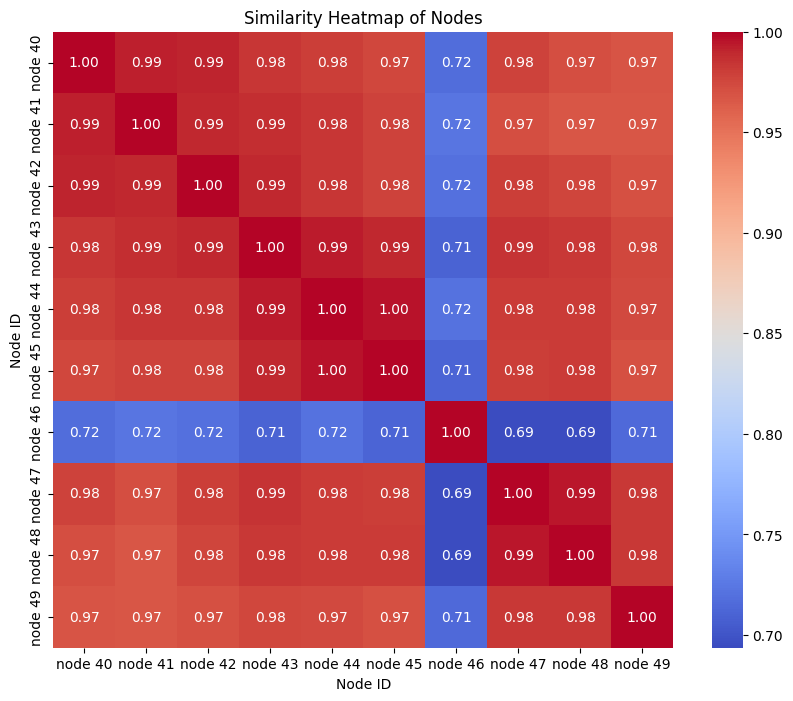

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

print('node', nodes[1])
for i in range(40, 50):
    doc1 = nlp(nodes[i].text)
    doc2 = nlp(nodes[1].text)
    similarity = doc1.similarity(doc2)
    print(f'Similarity between node {i} and node 1: {similarity}')

    

# Create a matrix to store the similarity values
similarity_matrix = np.zeros((10, 10))

# Fill the matrix with similarity values
for i in range(40, 50):
    doc1 = nlp(nodes[i].text)
    for j in range(40, 50):
        doc2 = nlp(nodes[j].text)
        similarity_matrix[i-40, j-40] = doc1.similarity(doc2)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=[f'node {i}' for i in range(40, 50)], yticklabels=[f'node {i}' for i in range(40, 50)])
plt.title('Similarity Heatmap of Nodes')
plt.xlabel('Node ID')
plt.ylabel('Node ID')
plt.show()

## Tiến hành query thử nghiệm.

In [10]:
vector_index = VectorStoreIndex(nodes)
query_engine = vector_index.as_query_engine()

In [11]:
text = "Tuổi xông đất tốt ? Gồm những năm nào ?"
# text = "đánh giá: Tuổi xông đất 1939 (Kỷ Mão - mệnh Hỏa) ?"
response = query_engine.query(
    text
)

print(response)

Tuổi xông đất tốt bao gồm năm 39 tuổi (Năm Bính Thìn) và năm 40 tuổi (Năm Đinh Tị).
